## DDPG Implementation on Gym's Pendulum

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import time as time

from PIL import Image
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple
from itertools import count
import random as random
import math as math
%matplotlib inline

#choose device cpu or cuda if a gpu is available
device=torch.device('cpu')
env = gym.make("Pendulum-v0")

# set up matplotlib to visulise images
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
#replay memory fucntion 
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):  #saves a transition
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
#define network class: 3 hidden layers with 8 neurons per layer


#critic network input is the a state-action vector

class DQN_critic(nn.Module):

    def __init__(self,input_size):
        super(DQN_critic, self).__init__()
        
        self.hidden1 = nn.Linear(input_size,8)
        self.hidden2 = nn.Linear(8,8)
        self.hidden3 = nn.Linear(8,8)
        self.output = nn.Linear(8,1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        return self.output(x.view(x.size(0), -1))
    
#actor network. Output is scaled in the action range and input is the state vector

HIGH_BOUND=2
LOW_BOUND=-2

class DQN_actor(nn.Module):

    def __init__(self,STATE_SIZE):
        super(DQN_actor, self).__init__()
        self.hidden1 = nn.Linear(STATE_SIZE,8)
        self.hidden2 = nn.Linear(8,8)
        self.hidden3 = nn.Linear(8,8)
        self.output = nn.Linear(8,1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        x=(torch.sigmoid(x)*(HIGH_BOUND - LOW_BOUND))+LOW_BOUND
        return x.view(x.size(0), -1)

In [4]:
#initialize neural nets
#size of state vector
STATE_SIZE=3

#size of action vector, it is single-valued because actions are continuous in the interval (-2,2)
ACTION_SIZE=1

#critic net with input (s,a) tensor and output a single q value for that state-action pair
critic_nn=DQN_critic(STATE_SIZE+ACTION_SIZE).to(device)
target_critic_nn=DQN_critic(STATE_SIZE+ACTION_SIZE).to(device)

#actor net: state input -- action output bounded from lower bound to high bound
actor_nn=DQN_actor(STATE_SIZE).to(device)
target_actor_nn=DQN_actor(STATE_SIZE).to(device)

#initialize replay memory
MEMORY_CAPACITY=1000000
memory=ReplayMemory(MEMORY_CAPACITY)

In [5]:
#soft target update function
def update_targets(target, original):
        """Weighted average update of the target network and original network
            Inputs: target actor(critic) and original actor(critic)"""
        
        for targetParam, orgParam in zip(target.parameters(), original.parameters()):
            targetParam.data.copy_((1 - TAU)*targetParam.data + TAU*orgParam.data)

In [6]:
#model optimization by mini batch

BATCH_SIZE=128
GAMMA=0.99
LEARNING_RATE_CRITIC=0.001
LEARNING_RATE_ACTOR=0.001
TAU=0.001

target_critic_nn.load_state_dict(critic_nn.state_dict())
optimizer_critic = optim.Adam(critic_nn.parameters(),lr=LEARNING_RATE_CRITIC)
target_critic_nn.eval()


target_actor_nn.load_state_dict(actor_nn.state_dict())
optimizer_actor = optim.Adam(actor_nn.parameters(), lr=LEARNING_RATE_ACTOR)
target_actor_nn.eval()

def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    #compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=device, dtype=torch.uint8)
    
    #divide memory into different tensors
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action).view(BATCH_SIZE,1)
    reward_batch = torch.cat(batch.reward)
    
    #create state-action (s,a) tensor for input into the critic network with taken actions
    state_action=torch.cat([state_batch,action_batch],-1)
    
    #compute Q(s,a) using critic network
    state_action_values = critic_nn.forward(state_action)
    
    #compute deterministic next state action using actor target network 
    next_action=target_actor_nn.forward(non_final_next_states).detach()
    
    #compute next timestep state-action (s,a) tensor for non-final next states
    next_state_action = torch.zeros(BATCH_SIZE,4, device=device)
    next_state_action[non_final_mask,:] = torch.cat([non_final_next_states,next_action],-1)
    
    #compute next state values at t+1 using target critic network
    next_state_values=target_critic_nn.forward(next_state_action).detach()
    
    #compute expected state action values y[i]= r[i] + Q'(s[i+1],a[i+1])
    expected_state_action_values = reward_batch.view(BATCH_SIZE,1) + GAMMA*(next_state_values)
    
    #critic loss by mean squared error
    loss_critic=F.mse_loss(state_action_values,expected_state_action_values)
    #optimize the critic network
    optimizer_critic.zero_grad()
    loss_critic.backward()
    
    for param in critic_nn.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer_critic.step()
    
    #optimize actor
    #actor actions
    state_actor_action=actor_nn.forward(state_batch)
    #state-actor-actions tensor
    state_actor_action_values=torch.cat([state_batch,state_actor_action],-1)
    #loss
    loss_actor=-1*torch.mean(critic_nn(state_actor_action_values))
    optimizer_actor.zero_grad()
    loss_actor.backward()
    for param in actor_nn.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer_actor.step()
                             
    #soft parameter update
    update_targets(target_critic_nn,critic_nn)
    update_targets(target_actor_nn,actor_nn)


In [7]:
#noise parameters

# scale of the exploration noise process (1.0 is the range of each action
# dimension)
NOISE_SCALE_INIT = 0.1

# decay rate (per episode) of the scale of the exploration noise process
NOISE_DECAY = 0.99

# parameters for the exploration noise process:
# dXt = theta*(mu-Xt)*dt + sigma*dWt
EXPLO_MU = 0.0
EXPLO_THETA = 0.15
EXPLO_SIGMA = 0.2

In [8]:
max_steps=1000
episodes=100
episode_reward=[0]*episodes
EPS=0.001



for i_episode in range(episodes):
    
    state=env.reset() #initial state
    state=torch.tensor([state],dtype=torch.float)
    
    # Initialize exploration noise process, parameters in parameters file
    noise_process = np.zeros(ACTION_SIZE)
    noise_scale = (NOISE_SCALE_INIT * NOISE_DECAY**EPS) * (HIGH_BOUND - LOW_BOUND)
    done=False
    for t in count():
        
        action=actor_nn(state).detach() #deterministic choice of a using actor network
        # add temporally-correlated exploration noise to action (using an Ornstein-Uhlenbeck process)
        noise_process = EXPLO_THETA * (EXPLO_MU - noise_process) + EXPLO_SIGMA * np.random.randn(ACTION_SIZE)
        noise=noise_scale*noise_process
        action += torch.tensor([noise[0]],dtype=torch.float,device=device)
        #perform an action
        next_state,reward,done,_=env.step(action)
        next_state=torch.tensor([next_state],dtype=torch.float)
        reward = torch.tensor([reward],device=device,dtype=torch.float)


        episode_reward[i_episode] += reward.item()

        #save transition into memory
        memory.push(state,action,next_state,reward)

        #move to the next state
        state=next_state

        #optimize de model
        optimize_model()
        #show the image
        
        
        #env.render()
        if t>max_steps or done:
            break

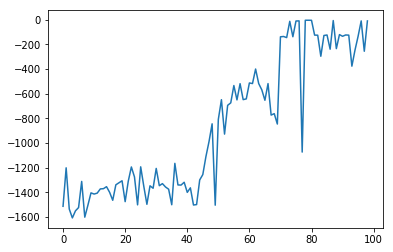

In [9]:
plt.plot(episode_reward[:i_episode])